In [1]:
# import 
from __future__ import absolute_import, division, print_function, unicode_literals
# 安装tfds pip install tfds-nightly==1.0.2.dev201904090105
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras.layers as layers
import sys
import fox_proxy
import time
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('.')
print(tf.__version__)

2.5.0-dev20201101


In [2]:
# use tfds load test data 
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True,download=False)
train_examples, val_examples = examples['train'], examples['validation']

In [3]:
# create tokenizer
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples),
                                                                         target_vocab_size=2**13)
tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for en, pt in train_examples),
                                                                         target_vocab_size=2**13)


In [4]:
# test
# sample  to encoding
sample_string = 'Transformer is awesome'
tokenized_string = tokenizer_en.encode(sample_string)
print('tokenized_string is {}'.format(tokenized_string))
original_string = tokenizer_en.decode(tokenized_string)
print('The original string is {}'.format(original_string))
assert original_string == sample_string
# 如果单词不在词典中，则分词器（tokenizer）通过将单词分解为子词来对字符串进行编码。
for ts in tokenized_string:
    print('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

tokenized_string is [7915, 1248, 7946, 7194, 13, 2799]
The original string is Transformer is awesome
7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome


In [5]:
# hyperparameter
BUFFER_SIZE = 20000
BATCH_SIZE = 64


In [6]:
# 将开始和结束标记（token）添加到输入和目标。
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
    lang1.numpy()) + [tokenizer_pt.vocab_size + 1]
    
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
    lang2.numpy()) + [tokenizer_en.vocab_size + 1]
    
    return lang1, lang2


In [7]:
# Note：为了使本示例较小且相对较快，删除长度大于40个标记的样本。
MAX_LENGTH = 40
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x)<= max_length,
                         tf.size(y)<= max_length)


In [8]:
# encode in tf
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64,tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])
    return result_pt, result_en


In [9]:
# train_dataset
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
#print('pause')
# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset =train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

pt_batch, en_batch = next(iter(val_dataset))
print(pt_batch, en_batch)

tf.Tensor(
[[8087 2978 1942 ...    0    0    0]
 [8087 1949 4957 ...    0    0    0]
 [8087 7682 1786 ...    0    0    0]
 ...
 [8087  830 2578 ...    0    0    0]
 [8087 5421    9 ...    0    0    0]
 [8087 1091 7863 ...    0    0    0]], shape=(64, 40), dtype=int64) tf.Tensor(
[[8087   98   25 ...    0    0    0]
 [8087   12   20 ...    0    0    0]
 [8087   12 5453 ...    0    0    0]
 ...
 [8087  115   11 ...    0    0    0]
 [8087   25   22 ...    0    0    0]
 [8087   15  381 ...    0    0    0]], shape=(64, 25), dtype=int64)


(1, 50, 512)


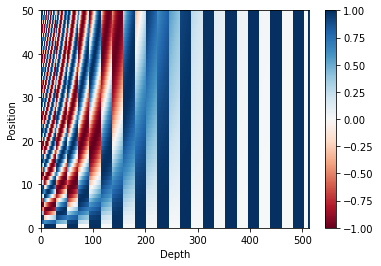

In [10]:
# position encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2) / np.float32(d_model)))
    return pos * angle_rates

def position_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # sin in position indices is even , 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:,0::2])
    # cos in position indices is odd , 2i+1
    angle_rads[:,1::2] = np.cos(angle_rads[:, 1::2])
    position_encoding = angle_rads[np.newaxis,...]
    return tf.cast(position_encoding, dtype=tf.float32)


# position encoding layer
pos_encoding = position_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [11]:
'''
遮挡（Masking）

遮挡一批序列中所有的填充标记（pad tokens）。
这确保了模型不会将填充作为输入。
该 mask 表明填充值 0 出现的位置：在这些位置 mask 输出 1，否则输出 0。
'''
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # 添加额外的维度来将填充加到
    # 注意力对数（logits）。
    return seq[:,tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

# test padding mask
x = tf.constant([[7,6,0,0,1],[1,2,3,0,0],[0,0,0,4,5]])
print(create_padding_mask(x))
print(" ")

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)
 


In [12]:
'''
前瞻遮挡（look-ahead mask）用于遮挡一个序列中的后续标记（future tokens）。
换句话说，该 mask 表明了不应该使用的条目。

这意味着要预测第三个词，将仅使用第一个和第二个词。
与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。
'''
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)
    return mask

# test look_ahead_mask
x = tf.random.uniform((1,3))
temp = create_look_ahead_mask(x.shape[1])
print(temp)
print(x.shape[1])

tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)
3


In [13]:
# 按比缩放的点积注意力（Scaled dot product attention）
# Attention qkv formula
# img/attention_formula.sv
# https://tensorflow.google.cn/images/tutorials/transformer/scaled_attention.png
def scaled_dot_product_attention(q,k,v,mask):
    """计算注意力权重。
     q, k, v 必须具有匹配的前置维度。
     k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
     虽然 mask 根据其类型（填充或前瞻）有不同的形状，
     但是 mask 必须能进行广播转换以便求和。

     参数:
       q: 请求的形状 == (..., seq_len_q, depth)
       k: 主键的形状 == (..., seq_len_k, depth)
       v: 数值的形状 == (..., seq_len_v, depth_v)
       mask: Float 张量，其形状能转换成
             (..., seq_len_q, seq_len_k)。默认为None。

     返回值:
       输出，注意力权重
     """
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1],tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add  mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_Weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_Weights, v)
    return output, attention_Weights


In [14]:
'''
当 softmax 在 K 上进行归一化后，它的值决定了分配到 Q 的重要程度。

输出表示注意力权重和 V（数值）向量的乘积。这确保了要关注的词保持原样，而无关的词将被清除掉。
'''
def print_out(q,k,v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print('Attention weights are :')
    print(temp_attn)
    print('Output is:')
    print(temp_out)


In [15]:
# test
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                     [0,10,0],
                     [0,0,10],
                     [0,0,10]], dtype=tf.float32)

temp_v = tf.constant([[1,0],
                      [10,0],
                      [100,5],
                      [1000,6]],dtype=tf.float32)

#test
# query 符合第二個主鍵 (key)
# 返回 第二個數值
temp_q = tf.constant([[0,10,0]],dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are :
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [16]:
# test
# query 符合 第三個跟第四個key
# 因此對所有的相關數值娶了平均
temp_q = tf.constant([[0,0,10]],dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)


Attention weights are :
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [17]:
# 这条请求符合第一和第二条主键，
# 因此，对它们的数值去了平均。
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are :
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [18]:
# 将所有请求一起传递。
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are :
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [19]:

'''
多头注意力由四部分组成：

    线性层并分拆成多头。
    按比缩放的点积注意力。
    多头及联。
    最后一层线性层。

每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。

将上面定义的 scaled_dot_product_attention 函数应用于每个头（进行了广播（broadcasted）以提高效率）。
注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用tf.transpose 和 tf.reshape），
并放入最后的 Dense 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。
在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。
'''
# multi-head attention layer
# https://tensorflow.google.cn/images/tutorials/transformer/multi_head_attention.png

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
       
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # floor divide

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, depth).
           转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  #(batch_size, seq_len, d_model)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # same
        v = self.split_heads(v, batch_size)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention) # (batch_size, seq_len_q,d_model)
        return output, attention_weights
    

In [20]:
'''
创建一个 MultiHeadAttention 层进行尝试。在序列中的每个位置 y，MultiHeadAttention
在序列中的所有其他位置运行所有8个注意力头，在每个位置y，返回一个新的同样长度的向量。

'''
# test
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1,50,512)) # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(v = y, k=y, q=y,mask=None)
out.shape, attn.shape


(TensorShape([1, 50, 512]), TensorShape([1, 8, 50, 50]))

In [21]:
'''
点式前馈网络（Point wise feed forward network）

点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。
'''
def point_wise_feed_forward_network(d_model, dff):
    FF = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'), # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model) #(batch_size, seq_len, d_model)
    ])
    return FF


In [22]:
# test
sample_ffn = point_wise_feed_forward_network(512, 2028)
sample_ffn(tf.random.uniform((64,50,512))).shape


TensorShape([64, 50, 512])

In [23]:

# encoder
'''
Transformer 模型与标准的具有注意力机制的序列到序列模型（sequence to sequence with attention model），遵循相同的一般模式。

    输入语句经过 N 个编码器层，为序列中的每个词/标记生成一个输出。
    解码器关注编码器的输出以及它自身的输入（自注意力）来预测下一个词。

编码器层（Encoder layer）

每个编码器层包括以下子层：

    多头注意力（有填充遮挡）
    点式前馈网络（Point wise feed forward networks）。

每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 LayerNorm(x + Sublayer(x))。归一化是在 d_model（最后一个）维度完成的。Transformer 中有 N 个编码器层。
'''
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer,self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output) #(batch_size, input_seq_len, d_model)
        ffn_out = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_out = self.dropout2(ffn_out, training=training)
        out2 = self.layernorm2(x + ffn_out)
        return out2

In [24]:
# test
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_latyer_out = sample_encoder_layer(tf.random.uniform((64, 43, 512)),False,None)
sample_encoder_latyer_out.shape #(batch_size, input_seq_len, d_model)


TensorShape([64, 43, 512])

In [25]:

#---------decoder layer
'''
解码器层（Decoder layer）

每个解码器层包括以下子层：

    遮挡的多头注意力（前瞻遮挡和填充遮挡）
    多头注意力（用填充遮挡）。V（数值）和 K（主键）接收编码器输出作为输入。Q（请求）接收遮挡的多头注意力子层的输出。
    点式前馈网络

每个子层在其周围有一个残差连接，然后进行层归一化。每个子层的输出是 LayerNorm(x + Sublayer(x))。
归一化是在 d_model（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到解码器的第一个注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入的重要性。
换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力，预测下一个词。参看按比缩放的点积注意力部分的演示。
'''

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model,dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.droupout1 = tf.keras.layers.Dropout(rate)
        self.droupout2 = tf.keras.layers.Dropout(rate)
        self.droupout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_out.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x,x,x,look_ahead_mask) # (batch_size, target_seq_len, d_model)
        attn1 = self.droupout1(attn1,training=training)
        out1 = self.layernorm1(attn1 + x)

        # (batch_size, target_seq_len, d_model)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.droupout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2) # (batch_size, target_seq_len, d_model)
        ffn_output = self.droupout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [26]:
# test
sample_decoder_layer = DecoderLayer(512,8, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64,50,512)), sample_encoder_latyer_out,False,None,None
)
sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)



TensorShape([64, 50, 512])

In [27]:

# ---------encoder
'''
编码器（Encoder）

编码器 包括：

    输入嵌入（Input Embedding）
    位置编码（Positional Encoding）
    N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。
编码器的输出是解码器的输入
'''
# dff ??
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding,rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = position_encoding(maximum_position_encoding, self.d_model)
        # dff parameter ?
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        # 将嵌入和位置编码相加。
        x =self.embedding(x) #(batch_size,input_seq_len,_d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))
        x += self.pos_encoding[:,:seq_len,:]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training, mask)
        return x # (batch_size, input_seq_len, d_model)



In [28]:
# test
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
sample_encoder_output = sample_encoder(tf.random.uniform((64,62)),training=None,mask=None)
print(sample_encoder_output.shape) # (batch_size, input_seq_len, d_model)


(64, 62, 512)


In [29]:

# Decoder

'''
解码器（Decoder）

解码器包括：

    输出嵌入（Output Embedding）
    位置编码（Positional Encoding）
    N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。
该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。
'''
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = position_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x) # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:,:seq_len, : ]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x, enc_output, training, look_ahead_mask, padding_mask
            )
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        # x.shape (batch_size, tartet_seq_len, d_model)
        return x, attention_weights
    

In [30]:
# test
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
output, attn = sample_decoder(tf.random.uniform((64,26)),
                              enc_output=sample_encoder_output,
                              training=False, look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [31]:

# transformer  class
'''
创建 Transformer

Transformer 包括编码器，解码器和最后的线性层。解码器的输出是线性层的输入，返回线性层的输出。
'''

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_traget, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)
        
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_traget, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask,
             dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask) # (batch_size, inp_seq_len, d_model)
        
        # dec_ output (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, 
            look_ahead_mask, dec_padding_mask
        ) 
        
        final_output = self.final_layer(dec_output) #(batch_size, tar_seq_len, target_vocab_size)
        return  final_output, attention_weights
    
    

In [32]:
# test
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_traget=6000
)

temp_input = tf.random.uniform((64,62))
temp_target = tf.random.uniform((64,26))
fn_out, _ = sample_transformer(temp_input,
                               temp_target,
                               training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)
fn_out.shape # batch_size, tar_seq_len, target_vocab_size


TensorShape([64, 26, 8000])

In [33]:
# Tansformer Alog. Declare end

In [34]:
#Prepare Training config

## hyperparameters
'''
配置超参数（hyperparameters）

为了让本示例小且相对较快，已经减小了num_layers、 d_model 和 dff 的值。

Transformer 的基础模型使用的数值为：num_layers=6，d_model = 512，dff = 2048。关于所有其他版本的 Transformer，请查阅论文。

Note：通过改变以下数值，您可以获得在许多任务上达到最先进水平的模型。
'''
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1


Text(0.5, 0, 'Train Step')

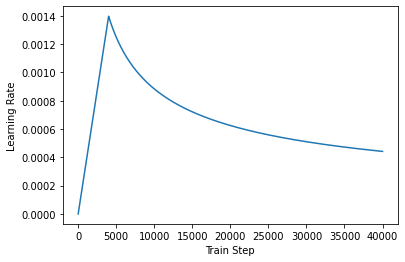

In [35]:

# optimizer ?
'''
优化器（Optimizer）

根据论文中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

'''
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warm_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warm_steps** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


# test
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")



In [36]:
# loss
'''
损失函数与指标（Loss and metrics）

由于目标序列是填充（padded）过的，因此在计算损失函数时，应用填充遮挡非常重要。
'''
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real,pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.type)
    loss_ *= mask
    return tf.reduce_mean(loss_)


# test
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalCrossentropy(
    name='train_accuracy')

In [37]:
# Training and checkpointing
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_traget=target_vocab_size,
                          rate=dropout_rate)

#
def create_masks(inp, tar):
    #編碼器填充遮擋
    enc_padding_mask = create_padding_mask(inp)

    #在編碼器的第二個注意力模塊使用
    #該填充的遮擋用於遮擋解碼器的輸出
    dec_padding_mask = create_padding_mask(inp)

    # 在解碼器的第一個注意力模塊使用
    # 用於填充(pad)和遮擋(mask)解碼器獲取到的輸入後的後續標記(future token)
    look_ahead_mask = create_padding_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


# 創建檢查點的路徑和檢查點管理器(manager) , 用於每n個週期(epochs)保存檢查點
checkpoint_path = './checkpoint/train'
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果檢查點存在，則恢復最新的檢查點
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored')






In [38]:

'''
目标（target）被分成了 tar_inp 和 tar_real。tar_inp 作为输入传递到解码器。tar_real 是位移了 1 的同一个输入：
在 tar_inp 中的每个位置，tar_real 包含了应该被预测到的下一个标记（token）。

例如，sentence = "SOS A lion in the jungle is sleeping EOS"

tar_inp = "SOS A lion in the jungle is sleeping"

tar_real = "A lion in the jungle is sleeping EOS"

Transformer 是一个自回归（auto-regressive）模型：它一次作一个部分的预测，然后使用到目前为止的自身的输出来决定下一步要做什么。

在训练过程中，本示例使用了 teacher-forcing 的方法（就像文本生成教程中一样）。无论模型在当前时间步骤下预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

当 transformer 预测每个词时，自注意力（self-attention）功能使它能够查看输入序列中前面的单词，从而更好地预测下一个单词。

为了防止模型在期望的输出上达到峰值，模型使用了前瞻遮挡（look-ahead mask）。
'''

EPOCHS = 20
'''
該 @tf.function 將追蹤-編譯train-step到TF圖中，以便更快地
執行，該函數專用於參數張量的精確形狀，為了避免由於可變序列長度
或可變批次大小(最後一批次較小)　導致的追蹤，使用input_signature
指定更多的通用形狀
'''
train_step_signature = [
    tf.TensorSpec(shape=(None,None),dtype=tf.float32),
    tf.TensorSpec(shape=(None,None), dtype=tf.float32)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask, #?
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accurancy(tar_real, predictions)




In [39]:

#　葡萄牙語做為輸入語言，英語作為目標語言
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()
            ))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                            ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f} '.format(
        epoch+1, train_loss.result(), train_accuracy.result()
    ))

    print('Time taken for 1 epoch: {} secs \n'.format(time.time()-start))



ValueError: in user code:

    <ipython-input-38-9c346cd641ce>:36 train_step  *
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    <ipython-input-37-c454183c2adb>:19 create_masks  *
        look_ahead_mask = create_padding_mask(tf.shape(tar)[1])
    <ipython-input-11-58af0505239c>:12 create_padding_mask  *
        return seq[:,tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\ops\array_ops.py:1047 _slice_helper
        name=name)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\ops\array_ops.py:1219 strided_slice
        shrink_axis_mask=shrink_axis_mask)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:10478 strided_slice
        shrink_axis_mask=shrink_axis_mask, name=name)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\framework\op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\framework\func_graph.py:598 _create_op_internal
        compute_device)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\framework\ops.py:3536 _create_op_internal
        op_def=op_def)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\framework\ops.py:2016 __init__
        control_input_ops, op_def)
    c:\programdata\anaconda3\envs\py37_t2_2\lib\site-packages\tensorflow\python\framework\ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Index out of range using input dim 0; input has only 0 dims for '{{node strided_slice_5}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=9, ellipsis_mask=0, end_mask=9, new_axis_mask=6, shrink_axis_mask=0](Cast_2, strided_slice_5/stack, strided_slice_5/stack_1, strided_slice_5/stack_2)' with input shapes: [], [4], [4], [4] and with computed input tensors: input[3] = <1 1 1 1>.
